## Practice Image Processing Steps Using Sample Images
In this Jupyter Notebook, you are going to practice the image processing steps we developed for the Nestle acne severity assessment application. 

We are using some publicly available face images (of President Obama) to show you the following steps:
1. Using face landmark model to detect facial landmarks and extract skin patches.
2. Rolling the skin patches vertically or horizontally, which helps significantly the trained deep learning transfer learning models generalize well on the testing images.

### Prerequisites
1. Download the facial landmark model from https://github.com/AKSHAYUBHAT/TensorFace/blob/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat and save it in directory ../models
2. Download the Haar Cascade one-eye model from https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml and save it in directory ../models

### Import necessary Python libraries

In [1]:
import copy
import cv2
import dlib
import imageio
import numpy as np
import os
import sys

from os import listdir
from os.path import join, isfile, splitext
from scipy import misc

import matplotlib.pyplot as plt
%matplotlib inline

### Specify the parameters for the skin patch extraction
The following parameters specify:
1. Where the raw images are: a directory with all facial images you want to process.
2. Where to output the cropped skin patches. 
3. Where the one-eye Haar Cascade model is.
4. Where the landmark model is.
5. Other parameters to determine the skin patches when one-eye model is applied on the facial image. 

In [2]:
originalFile_Dir = "../data/demo_images" # Location of the raw images.
croppedFaces_Dir = "../data/demo_images_patches" # Location to store the skin patch images.
Eye_Cascade_Path = "../models/haarcascade_eye.xml"
PREDICTOR_PATH = "../models/shape_predictor_68_face_landmarks.dat"

verb = True # If verb = False, extracted skin patches will not be displayed on the Jupyter notebook. 
             # Otherwise, extracted skin patches for each raw image will be displayed on the Jupyter notebook. 
             # Set verb = True if you want to inspect the result of the skin patch extraction to make sure you are getting the 
             # skin patches as expected. Do this on a small subset of your images, and set it to False and run it on the entire
             # image set after you are comfortable with the results. 
width_ratio = 1.5 # This parameter controls the width of the forehead if One Eye model is used to infer the forehead. If left cheek
                  # is determined to be facing the camera, in x direction, extracted forehead skin patch starts at the left edge
                  # of the detected eye, and ends at min(image width, eye's left edge + width\_ratio *  eye's width)
                  # If right cheek is determed to be facing the camera, in x direction, forehead starts at 
                  # max(0, eye's left edge - width\_ratio * eye's width), and ends at 
                  # min(image width, eye's left edge + width\_ratio * eye's width) 
top_ratio = 1.5   # This parameter controls the height of the forehead if One Eye model is used to infer the forehead. 
                  # In y direction, forehead starts at max(0, eye's top edge - top\_ratio * eye's height), and ends at 
                  # max(0, eye's top edge - 0.5 * eye's height). 0.5 here is to skip the eyebrow. 
down_ratio = 4.5  # This parameter controls how much we are going down from the detected eye's by the One Eye model in order to get 
                  # the cheek skin patch. In y direction, cheek starts at the lower edge of the detected eye, and ends 
                  # at min(image height, eye's top edge + down\_ratio * eye's height)
cheek_width_ratio = 2.8 # This parameter controls the width of the cheek skin patch if One Eye model is used. 
                        # If left cheek is determined to be facing the camera, in x direction, cheek starts at 
                        # the right edge of the eye, and ends at 
                        # min(image width, (eye's left edge + cheek\_width\_ratio + 0.5) * eye's width).
                        # If right cheek is determed to be facing the camera, in x direction, cheek starts at 
                        # max(0, eye's left edge - cheek\_width\_ratio * eye's width), and ends at 
                        # eye's left edge + 0.5*eye's width
forehead_ratio = 0.3    # This parameter controls the height of forehead when facial landmark model is working. 
                        # The extracted forehead height will be forehead\_ratio * face\_height, where face\_height is 
                        # the distance in y direction between the highest eyebrow and the lowest landmark points (the bottom point)
                        # of the chin. Then, the forehead skin patch, in y direction, starts at 
                        # max(0, highest eyebrow - forehead\_height), and ends at 
                        # min(highest eyebrow, forehead top edge + forehead\_height)



### Initialize the one-eye model and the landmark model

In [3]:
ye_cascade = cv2.CascadeClassifier(Eye_Cascade_Path) # Initialize the Eye cascade model

#####################################################
# These are the default parameters for landmark model
# Do not change them.
#####################################################
SCALE_FACTOR = 1 
FEATHER_AMOUNT = 11

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))
######################################################
# Above are the default parameters for landmark model.
######################################################

# Points used to line up the images.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Points from the second image to overlay on the first. The convex hull of each
# element will be overlaid.
# Do not need it since it is not an overlay problem
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Amount of blur to use during colour correction, as a fraction of the
# pupillary distance.
#COLOUR_CORRECT_BLUR_FRAC = 0.6

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH) # Initialize the landmark model



### Utility functions defined to use one-eye model and landmark model to extract skin patches

In [4]:
class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def get_landmarks(im):
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)

    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    im = np.array([im, im, im]).transpose((1, 2, 0))

    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im
    
def transformation_from_points(points1, points2):
    """
    Return an affine transformation [s * R | T] such that:
        sum ||s*R*p1,i + T - p2,i||^2
    is minimized.
    """
    # Solve the procrustes problem by subtracting centroids, scaling by the
    # standard deviation, and then using the SVD to calculate the rotation. See
    # the following for more details:
    #   https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem

    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = np.linalg.svd(points1.T * points2)

    # The R we seek is in fact the transpose of the one given by U * Vt. This
    # is because the above formulation assumes the matrix goes on the right
    # (with row vectors) where as our solution requires the matrix to be on the
    # left (with column vectors).
    R = (U * Vt).T

    return np.vstack([np.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         np.matrix([0., 0., 1.])])

def read_im_and_landmarks(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)

    return im, s

def warp_im(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def correct_colours(im1, im2, landmarks1):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(np.float64) * im1_blur.astype(np.float64) /
                                                im2_blur.astype(np.float64))

# This function infers the region of either left or right cheek. The inferred cheek region will be used to 
# determine whether it is a left or a right cheek. 
def infer_cheek_region(eye, width_ratio, down_ratio, left_or_right):
    region1 = [0] * 4
    if left_or_right == 'right': #assuming it is the absolute right chin
        region1[0] = int(max(0, int(eye[0] - 0.5 * eye[2]))) #cheek region should go lefwards
        region1[2] = int(0.5 * eye[2])
    else: # assuming it is the absolute left cheek
        region1[0] = int(eye[0] + eye[2]) # cheek region should go rightwards
        region1[2] = int(0.5 * eye[2])
    region1[1] = int(eye[1] + eye[3])
    region1[3] = int(1.5 * eye[3])
    return region1

# This function determines whether it is a left or a right cheek. The determination is pretty heuristic. 
# We assume that when the left cheek is facing the camera, the patch on the left side of the region under the eye should 
# have higher variation than the right side since the left side will be more background, and the right side will have 
# lower variation since the right side will be mostly face skin.
# On the other side, if the right cheek is facing the camera, the patch on the left side will be mostly skin, and right side 
# will be mostly background. Therefore right side will have higher variation than the left side. 

def detect_face_direction(gray, face, eye, down_ratio, cheek_width_ratio):  
    region1 = [0] * 4 # assuming this is the left eye, forhead should go rightward
    region2 = [0] * 4 # assuming this is the right eye, forhead should go leftward
    region1 = infer_cheek_region(eye[0], cheek_width_ratio, down_ratio, 'left') #region1 is from eye to right
    region2 = infer_cheek_region(eye[0], cheek_width_ratio, down_ratio, 'right') # region2 is from eye to left
    std1 = np.std(gray[region1[1]:(region1[1]+region1[3]), region1[0]:(region1[0]+region1[2])])
    std2 = np.std(gray[region2[1]:(region2[1]+region2[3]), region2[0]:(region2[0]+region2[2])])
    face_direction = ""
    if std1 > std2:  #eye right has higher variance than eye left
        face_direction = "right"
    else:
        face_direction = "left"
    return face_direction

# Extract cheek patches based on face landmarks and eye landmarks, and whether it is left cheek or right cheek
def extract_cheek_region(face_x_min, face_x_max, face_y_max, eye_landmarks, left_or_right):
    if left_or_right == "Left":
        cheek_region_min_x = eye_landmarks[0,0] # left cheek, x direction, cheek starts at the most inner point of left eye,
                                                # and ends with the face_x_max - a margin value. The margin value is 0.05 * 
                                                # (face_x_max - most inner point of left eye). This margin is set to avoid hair 
                                                # or other backgrounds
        cheek_region_max_x = int(face_x_max - 0.05 * (face_x_max - min(eye_landmarks[:,0])))
    else:
        cheek_region_max_x = eye_landmarks[-1, 0] # right cheek, x direction, cheek starts at the face_x_min + a margin, 
                                                  # where the margin is 0.1 * (cheek_region_max_x - face_x_min). This margin is set 
                                                  # to avoid hair or other backgrounds, and ends at the most inner point of right eye
        cheek_region_min_x = int(face_x_min + 0.1 * (cheek_region_max_x - face_x_min)) 
    # y direction, cheek starts at lowest eye landmarks + 0.2 * eye height. 0.2 * eye height is to avoid the skin that might be 
    # dominated by eyelash
    cheek_region_min_y = int(max(eye_landmarks[:,1]) + 0.2 * (max(eye_landmarks[:,1])  - min(eye_landmarks[:,1])))
    cheek_region_max_y = int(face_y_max - 0.1 * (face_y_max - max(eye_landmarks[:,1])))
    return [cheek_region_min_x, cheek_region_min_y, cheek_region_max_x, cheek_region_max_y]

### Work on each image to extract skin patches

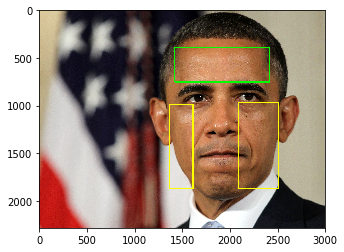

In [5]:
# Get the list of images in the directory of the original images     
imageFiles = [join(originalFile_Dir, f) for f in listdir(originalFile_Dir) if isfile(join(originalFile_Dir, f))]
num_images = len(imageFiles)
image_counter = 0

# If you want to only work on a small subset of the images, change the following parameters
start_index = 0
end_index = num_images

for imagefile in imageFiles[start_index:end_index]:
    image_counter += 1
    imageName = splitext(os.path.basename(imagefile))[0] # Get the root name of the image (without extension). This variable will be 
                                                         # used to generate the skin patch file name.
    face_detected = False
    try:
        img, landmarks = read_im_and_landmarks(imagefile) # Try if landmark model works. If it works, image is already read into img
        face_detected = True
    except:
        img = cv2.imread(imagefile) # if landmark model does not work, read the image 
        face_detected = False
    img_height, img_width = img.shape[0:2] #get the image height and width. Image data is in the format of [height, width, channel]
    min_dim = min(img_height, img_width)
    min_face_size = min_dim * 0.2 # Specify the minimal face size. Heuristic. 
    min_eye = min_face_size * 0.2 # specify the minimal eye size. 
    min_eye_area = min_eye ** 2 # specify the miniaml area of the eye. This is used screen detected eyes by the OneEye model.
                                # Keep in mind, the One Eye model will identify whatever looks like an eye. We need to screen out
                                # those that are too small. 
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Convert image from BGR to GRAY. OpenCV reads images in as BGR. One Eye model 
                                                 # works on gray scale images. 
    
    if face_detected: # if face is detected by landmark model
        mask = get_face_mask(img, landmarks) 
        face_x_min = int(max(0, np.asarray(min(landmarks[:,0])).flatten()[0])) #Get the minimal value of the detected landmarks in x
        face_x_max = int(min(img_width, np.asarray(max(landmarks[:,0])).flatten()[0])) # Get the maximal value of the detected landmarks in x
        face_y_min = int(max(0, np.asarray(min(landmarks[:,1])).flatten()[0])) # Get the minimal value of the detected landmarks in y
        face_y_max = int(min(img_height, np.asarray(max(landmarks[:,1])).flatten()[0])) # Get the maximal value of the detected landmarks in y
        face_height = face_y_max - face_y_min # Get the height of face
        forehead_height = int(face_height * forehead_ratio) # Ideally, forehead height should be 1/2 of the height between eyebrow and bottom of chin
                                                            # We choose forehead_ratio = 0.3 to avoid hairs on the forehead.
        new_face_y_min = max(0, face_y_min - forehead_height) # new_face_y_min is the top edge of the forehead. 
        right_brow_landmarks = landmarks[RIGHT_BROW_POINTS,:]
        left_brow_landmarks = landmarks[LEFT_BROW_POINTS,:]
        right_eye_landmarks = landmarks[RIGHT_EYE_POINTS,:]
        left_eye_landmarks = landmarks[LEFT_EYE_POINTS,:]
        mouse_landmarks = landmarks[MOUTH_POINTS,:]
        ########################
        # Get the forehead patch
        ########################
        [right_brow_min_x, left_brow_max_x] = \
            [max(0, np.min(np.array(right_brow_landmarks[:,0]))), min(img_width, np.max(np.array(left_brow_landmarks[:,0])))]
        brow_min_y = min(np.min(np.array(right_brow_landmarks[:,1])),np.min(np.array(left_brow_landmarks[:,1])))
        forehead_x_min = right_brow_min_x # forehead starts at the left landmark of the right eye brow
        forehead_x_max = left_brow_max_x
        forehead_y_min = max(0, brow_min_y - forehead_height)
        forehead_y_max = min(brow_min_y, forehead_y_min + forehead_height)
        forehead_region = img[forehead_y_min:forehead_y_max, forehead_x_min:forehead_x_max, :]
        forehead_file_name = join(croppedFaces_Dir, imageName+"_fh.jpg")
        # BGR image needs to be converted to RGB before saving as image file
        forehead_region = cv2.cvtColor(forehead_region, cv2.COLOR_BGR2RGB)
        imageio.imwrite(forehead_file_name, forehead_region)
        
        chin_x_min = np.max(np.array(right_eye_landmarks[:,0])) #In x direction, chin patch will be between the two most inner
                                                                #points of eyebrows
        chin_x_max = np.min(np.array(left_eye_landmarks[:,0]))
        chin_y_min = np.max(np.array(mouse_landmarks[:,1])) #In y direction, chin patch starts at the lowest point of mouse landmarks
        chin_y_max = face_y_max # In y direction, chin patch ends at the lowest point of face
        chin_region = img[chin_y_min:chin_y_max, chin_x_min:chin_x_max, :]
        chin_file_name = join(croppedFaces_Dir, imageName+"_chin.jpg")
        chin_region = cv2.cvtColor(chin_region, cv2.COLOR_BGR2RGB)
        imageio.imwrite(chin_file_name, chin_region)
        
        ##########################
        # Get the cheeks patch
        ##########################
        # Decide whether it is a side view or not. If the the left eye is 15% wider than the right eye, we determine
        # that it is the left cheek facing the camera. 
        # If the right eye is 15% wider than the left eye, we determine that it is the right cheek facing the camera. 
        # Under such situation, we only extract one cheek patch. 
        left_eye_width = np.max(np.array(left_eye_landmarks[:,0])) - np.min(np.array(left_eye_landmarks[:,0]))
        right_eye_width = np.max(np.array(right_eye_landmarks[:,0])) - np.min(np.array(right_eye_landmarks[:,0]))
        right_face = True
        left_face = True
        if float(right_eye_width) / float(left_eye_width) >= 1.15: # right eye is bigger than left eye, showing the right face
            left_face = False
        elif float(left_eye_width) / float(right_eye_width) >= 1.15: # left eye is bigger than right eye, showing the left face
            right_face = False
        
        if right_face:
            right_cheek_region = extract_cheek_region(face_x_min, face_x_max, face_y_max, right_eye_landmarks, "Right")
            cheek_region = img[right_cheek_region[1]:right_cheek_region[3], right_cheek_region[0]:right_cheek_region[2], :]
            cheek_file_name = join(croppedFaces_Dir, imageName+"_rc.jpg")
            cheek_region = cv2.cvtColor(cheek_region, cv2.COLOR_BGR2RGB)
            imageio.imwrite(cheek_file_name, cheek_region)
        if left_face:
            left_cheek_region = extract_cheek_region(face_x_min, face_x_max, face_y_max, left_eye_landmarks, "Left")
            cheek_region = img[left_cheek_region[1]:left_cheek_region[3], left_cheek_region[0]:left_cheek_region[2], :]
            cheek_file_name = join(croppedFaces_Dir, imageName+"_lc.jpg")
            cheek_region = cv2.cvtColor(cheek_region, cv2.COLOR_BGR2RGB)
            imageio.imwrite(cheek_file_name, cheek_region)
        # if verb == True, display the detected skin patches on the original image, using rectangle to highlight the skin patches
        if verb:
            img_tmp = img
            img_tmp = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB)
            cv2.rectangle(img_tmp, (forehead_x_min, forehead_y_min), (forehead_x_max, forehead_y_max), (0, 255, 0), 10)
            if right_face:
                cv2.rectangle(img_tmp, (right_cheek_region[0], right_cheek_region[1]), \
                              (right_cheek_region[2], right_cheek_region[3]), (255, 255, 0), 10)
            if left_face:
                cv2.rectangle(img_tmp, (left_cheek_region[0], left_cheek_region[1]), \
                              (left_cheek_region[2], left_cheek_region[3]), (255, 255, 0), 10)
            plt.imshow(img_tmp)
                
    if not face_detected:
        print("Face not detected by landmarks model...")
        # Use the OneEye model to detect one eye, and infer the face region based on the eye location
        eye_detected = False
        roi_gray = gray
        roi_color = img
        roi_color = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 5)
        max_area = 0
        eye_count = 0
        max_index = 0
        
        for (ex,ey,ew,eh) in eyes: # there might be multiple eyes detected. Choose the biggest one
            if ew*eh >= max_area and ex >= img_width * 0.1 and ex <= img_width * 0.9:
                max_area = ew*eh
                max_index = eye_count
            eye_count += 1
        if max_area >= min_eye_area: # if area of maximal eye is greater than the eye area threshold, take it as a real eye
            eye_detected = True
            (ex, ey, ew, eh) = eyes[max_index]
            if float(ew) / float(img_width) > 0.15 or float(eh) / float(img_height) > 0.15: # detected eye too large
                # resize the detected eye
                center_x = ex + ew/2
                center_y = ey + eh/2
                resized_w = min(img_width * 0.15, img_height * 0.15) # resize the eye
                ex = int(center_x - resized_w/2)
                ey = int(center_y - resized_w/2)
                ew = int(resized_w)
                eh = int(resized_w)
                eyes1 = np.array([ex, ey, resized_w, resized_w]).reshape((1,4))
            else:
                eyes1 = np.array(eyes[max_index]).reshape((1,4))
            face1 = np.array(())
            face_direction = detect_face_direction(gray, face1, eyes1, down_ratio, cheek_width_ratio)
            if face_direction == "left":
                print("Left eye detected")
                face_min_x = eyes1[0, 0]
                face_max_x = min(img_width, int(eyes1[0,0] + (cheek_width_ratio + 0.5) * eyes1[0, 2]))
                forehead_max_x = min(img_width, int(eyes1[0,0] + width_ratio * eyes1[0, 2]))
                forehead_min_x = face_min_x
                cheek_min_x = int(eyes1[0, 0] + 0.5 * eyes1[0,2])
                cheek_max_x = face_max_x
            else:
                print("Right eye detected")
                face_min_x = max(0, int(eyes1[0, 0] - cheek_width_ratio * eyes1[0, 2]))
                face_max_x = eyes1[0, 0] + eyes1[0, 2]
                forehead_min_x = max(0, int(eyes1[0, 0] - width_ratio * eyes1[0, 2]))
                forehead_max_x = min(img_width, int(eyes1[0, 0] + width_ratio * eyes1[0, 2]))   
                cheek_max_x = int(eyes1[0,0] + 0.5*eyes1[0,2])
                cheek_min_x = face_min_x
            forehead_min_y = max(0, int(eyes1[0, 1] - top_ratio * eyes1[0,3]))
            forehead_max_y = max(0, int(eyes1[0, 1] - 0.5 * eyes1[0, 3]))
            forehead_ok = False
            # Get the forehead region
            if forehead_max_y - forehead_min_y >= 0.7 * eyes1[0, 3]:
                forehead_ok = True
                forehead_region = img[forehead_min_y:forehead_max_y, forehead_min_x: forehead_max_x, :]
                forehead_region = cv2.cvtColor(forehead_region, cv2.COLOR_BGR2RGB)
                forehead_file_name = join(croppedFaces_Dir, imageName+"_fh.jpg")
                imageio.imwrite(forehead_file_name, forehead_region)
            # Get the cheek region
            cheek_min_y = int(eyes1[0, 1] + eyes1[0, 3])
            cheek_max_y = min(img_height, int(eyes1[0, 1] + down_ratio * eyes1[0, 3]))
            cheek_region = img[cheek_min_y: cheek_max_y, cheek_min_x: cheek_max_x, :]
            cheek_region = cv2.cvtColor(cheek_region, cv2.COLOR_BGR2RGB)
            if face_direction == "left":
                cheek_file_name = join(croppedFaces_Dir, imageName+"_lc.jpg")
            elif face_direction == "right":
                cheek_file_name = join(croppedFaces_Dir, imageName+"_rc.jpg")
            else:
                cheek_file_name = join(croppedFaces_Dir, imageName+"_c.jpg")
            imageio.imwrite(cheek_file_name, cheek_region)
            if verb:
                image = img
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                if forehead_ok:
                    cv2.rectangle(image, (forehead_min_x, forehead_min_y), \
                                  (forehead_max_x, forehead_max_y), (0, 255, 0), 5)
                cv2.rectangle(image, (cheek_min_x, cheek_min_y), \
                              (cheek_max_x, cheek_max_y), (255, 255, 0), 5)
                cv2.rectangle(image,(ex,ey),(ex+ew,ey+eh), (0,255,0), 5)
                               
                plt.imshow(image)
                #plt.imshow(roi_color)
    if (not face_detected) and (not eye_detected): # no face detected, nor eye detected, save the entire image and write to dest
        print("No cheeks or forehead detected, output the original file %s.jpg"%imageName)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if verb:
            plt.imshow(img)
        outfile = join(croppedFaces_Dir, imageName+".jpg")
        imageio.imwrite(outfile, img)

    if image_counter % 500 == 0: # Report the progress on image processing every 500 images processed
        print("%d images have been processed."%image_counter)

### Define skin patch rolling function

In [6]:
def roll_and_plot(img, file_name_wo_ext, x_or_y, pixels, verb):
    img_height, img_width = img.shape[0:2]
    img2 = copy.copy(img)
    if x_or_y == 'x':
        img2[:, 0:(img_width-pixels),:] = img[:,pixels:img_width,:]
        img2[:,(img_width-pixels):img_width,:] = img[:,0:pixels,:]
    else:
        img2[0:(img_height-pixels), :, :] = img[pixels:img_height, :, :]
        img2[(img_height-pixels):img_height, :,:] = img[0:pixels,:, :]
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)        

    if verb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        f, axarr = plt.subplots(2,1)
        axarr[0].imshow(img)
        axarr[1].imshow(img2)
    return


### Demonstrating the skin patch rolling process

In [7]:
root_dir = "../data"
source_dir = "demo_images_patches"
image_names = next(os.walk(join(root_dir, source_dir)))[2]

roll image Barack-Obama-Wallpaper_chin.jpg



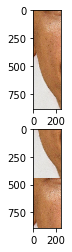

In [8]:
roll_ratio = 2
num_times = 1

patch_image_name = image_names[1]
print ('roll image %s'%patch_image_name)
print ()

# dest_path = join(root_dir, dest_dir) #destination path at the image class level
image_name_no_ext = splitext(patch_image_name)[0]

patch_image_path = join(root_dir, source_dir, image_names[0])
img = cv2.imread(patch_image_path)

img_height, img_width = img.shape[0:2]

# dertermine the rolling direction
if 'fh' in patch_image_name: # forehead image patches, rolling right to left
    x_or_y = 'x'
else: #if cheeks, or chins, rolling bottom to top
    x_or_y = 'y'

# dertermine rolling step size
if x_or_y == 'x':
    step_size = int(np.floor(np.float(img_width)/np.float(num_times+1))) 
else:
    step_size = int(np.floor(np.float(img_height)/np.float(num_times+1)))

    
for j in range(num_times):
    image_names = roll_and_plot(img, image_name_no_ext, x_or_y, step_size*(j+1), True)